# Import Libraries and Data Loading

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# Đọc dữ liệu từ file Excel
df = pd.read_excel('data.xlsx')
df

,TIME,CPI,IIR,M2,IIP,ER,CREDIT,WTI,Gold,USD,VN-Index,USD/VND,Trade,Interest-FED,CPI2
0,2009-01-01,17.469,7.88,20.76,76.20,16978.0,1412878.00,41.630909,103.64,101.48,303.21,17484.5,443.281573,0.15,0.32
1,2009-02-01,14.762,7.59,24.14,78.99,16972.0,1429268.00,39.078500,109.59,102.40,245.74,17480.5,847.958418,0.22,1.17
2,2009-03-01,11.257,7.41,26.54,88.06,16954.0,1488011.00,47.980000,115.55,102.60,280.67,17786.0,211.647053,0.18,-0.17
3,2009-04-01,9.231,7.32,32.47,87.82,16937.0,1552442.00,49.905909,117.17,103.88,321.63,17783.0,-1249.972824,0.15,0.35
4,2009-05-01,5.586,6.96,33.88,89.20,16938.0,1600412.00,59.257143,117.88,105.18,411.64,17775.0,-1286.268515,0.18,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2023-08-01,2.958,1.35,8.00,99.88,23977.0,12588304.72,81.372609,103.93,98.84,1224.05,24060.0,3591.981799,5.33,0.88
176,2023-09-01,3.651,1.52,9.31,97.54,24089.0,12754669.12,89.240952,104.91,100.35,1154.15,24280.0,2380.083830,5.33,1.08
177,2023-10-01,3.600,2.48,9.55,104.00,24087.0,12808476.25,85.469091,105.87,101.56,1028.19,24560.0,2908.724742,5.33,0.08
178,2023-11-01,3.450,1.13,10.15,104.02,23891.0,13019793.99,77.575455,108.80,101.61,1094.13,24250.0,1752.122845,5.33,0.25


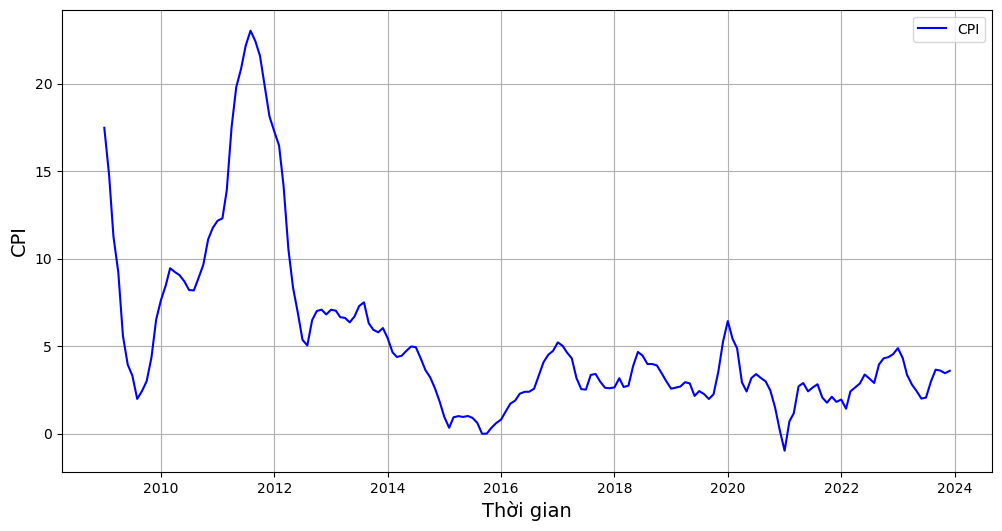

In [3]:
# Vẽ đồ thị CPI
# Đảm bảo cột TIME là kiểu datetime
df['TIME'] = pd.to_datetime(df['TIME'])

plt.figure(figsize=(12, 6))
plt.plot(df['TIME'], df['CPI'], label='CPI', color='blue')
plt.xlabel('Thời gian', fontsize=14)
plt.ylabel('CPI', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

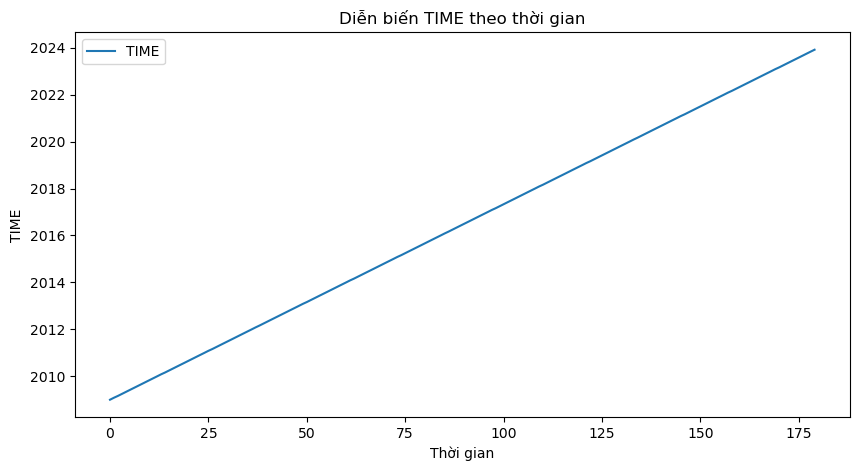

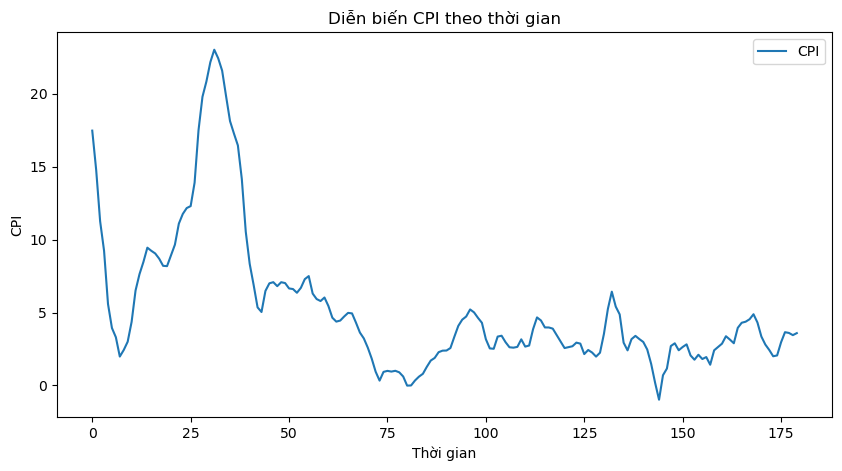

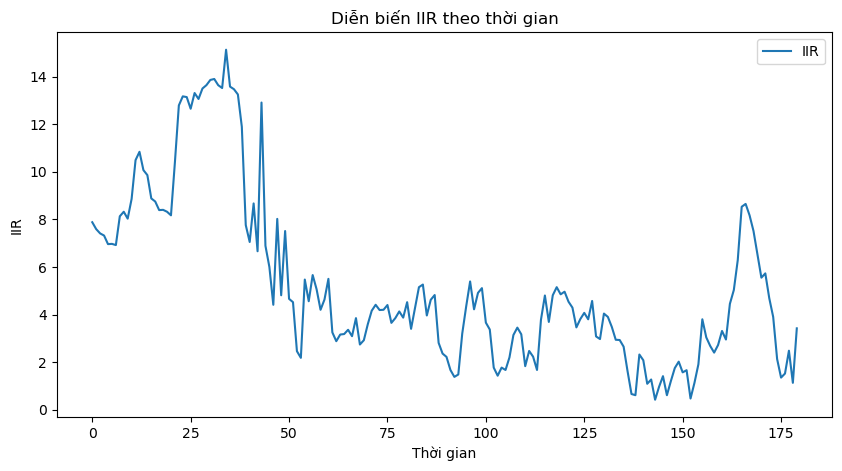

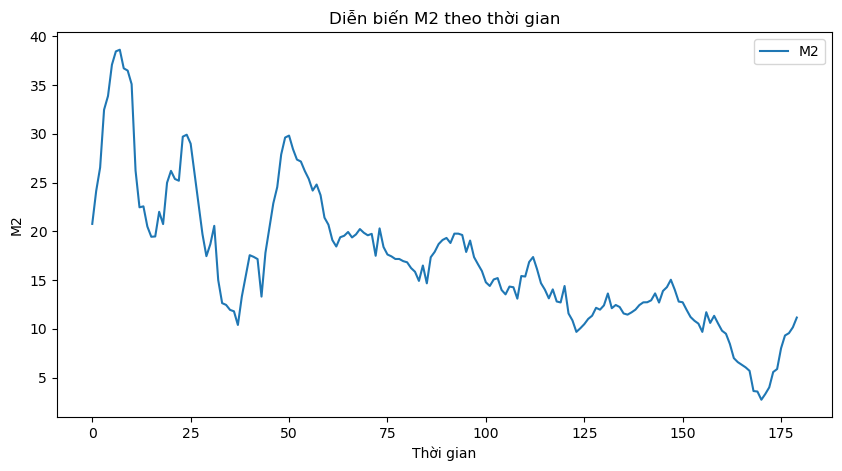

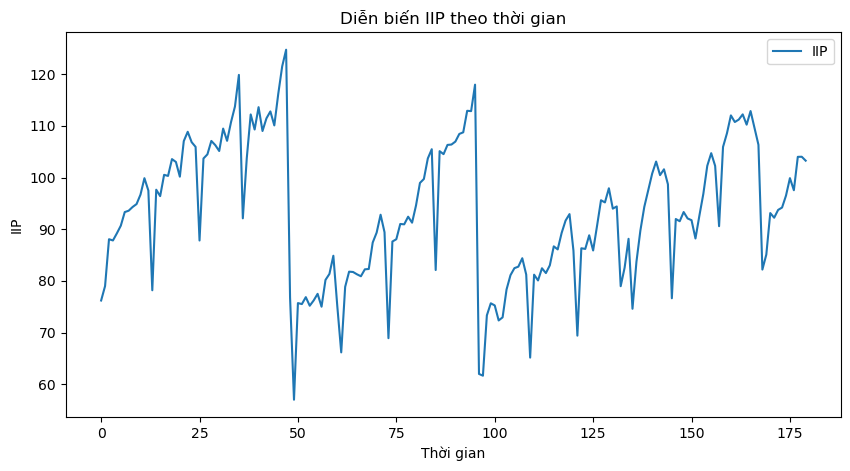

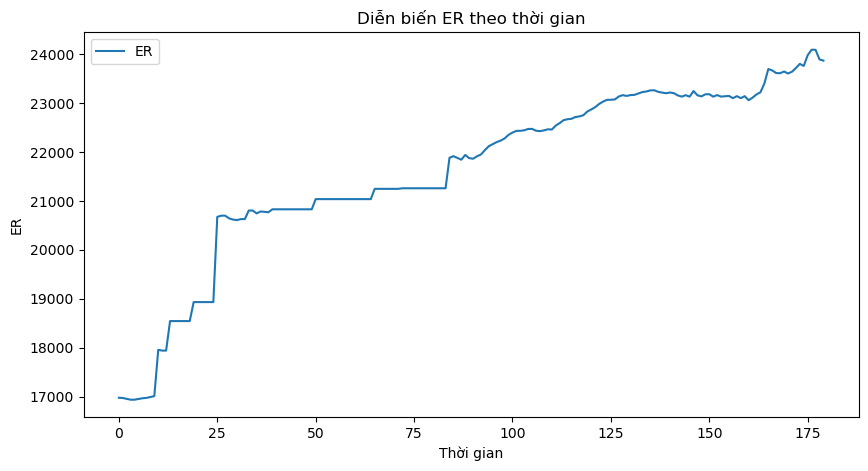

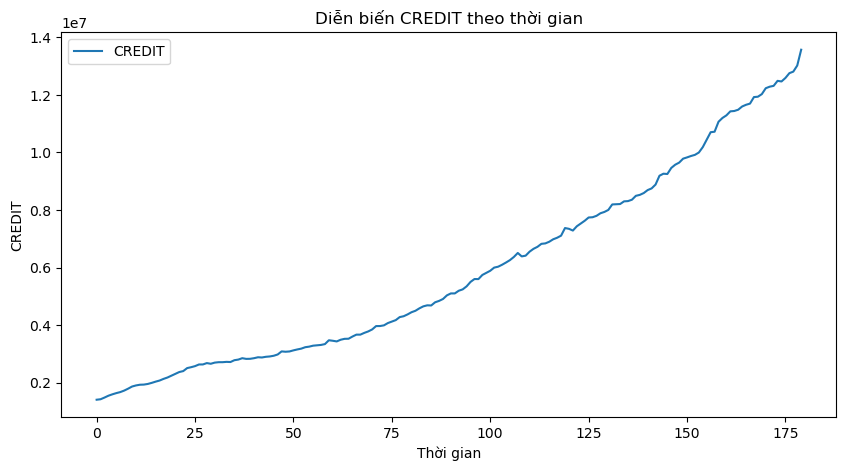

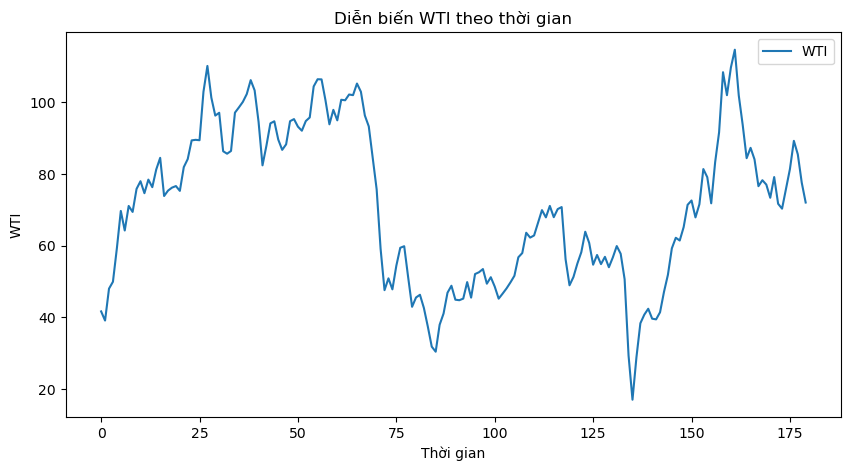

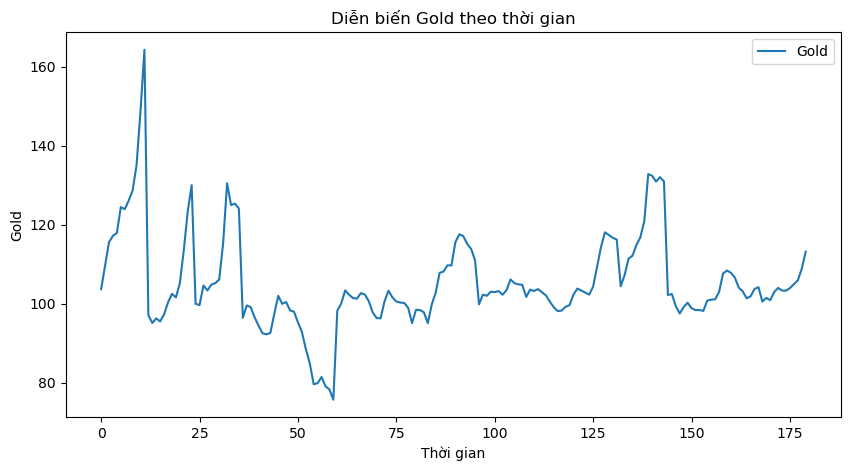

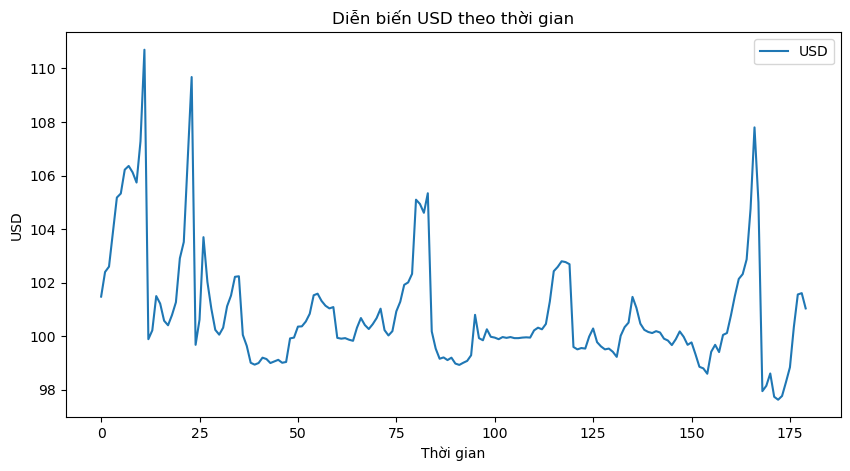

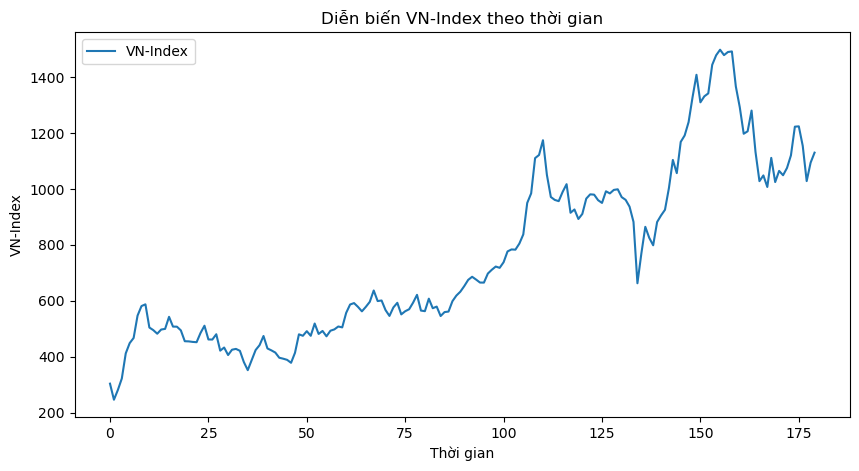

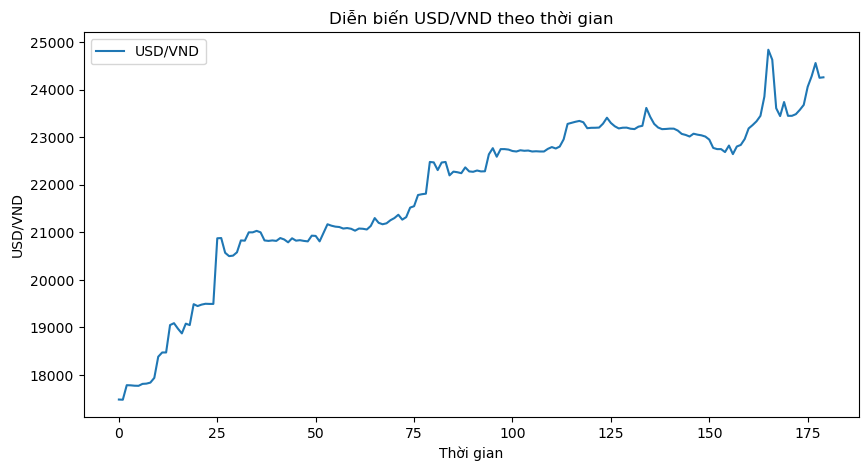

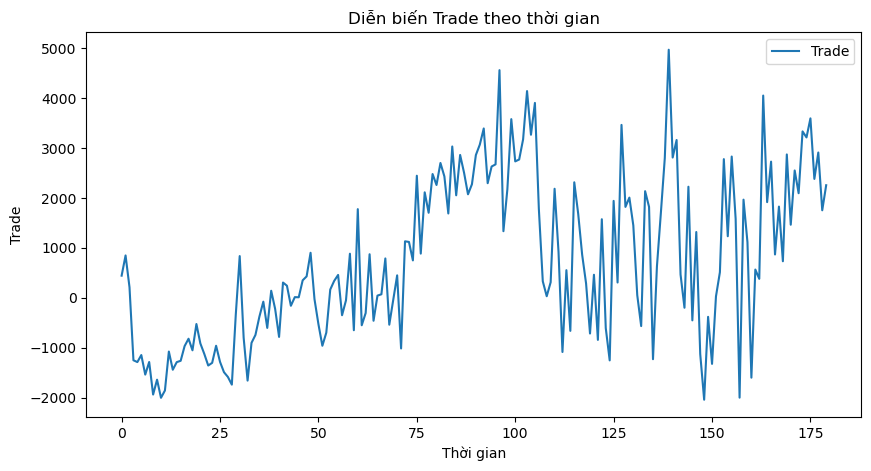

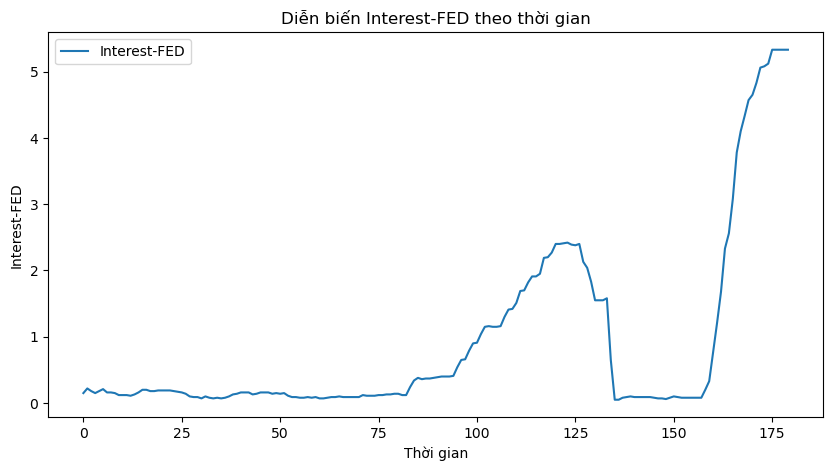

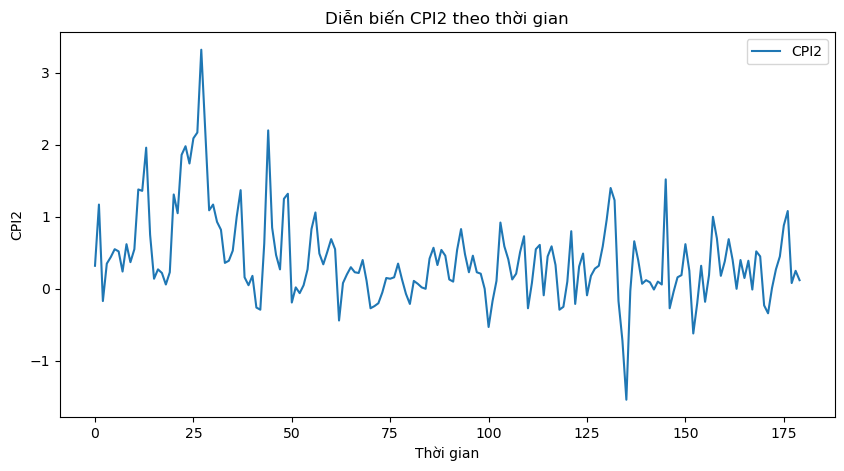

In [4]:
# Tạo một danh sách các biến cần vẽ
variables = df.columns.tolist()

# variables = features + [target]

# Vẽ từng đồ thị cho từng biến
for var in variables:
    plt.figure(figsize=(10, 5))
    plt.plot(df[var], label=var)
    plt.title(f'Diễn biến {var} theo thời gian')
    plt.xlabel('Thời gian')
    plt.ylabel(var)
    plt.legend()
    plt.show()

# A. LSTM Model

## 1. Chuẩn bị dữ liệu

In [5]:
# Lựa chọn các biến độc lập và phụ thuộc
features = ['IIR', 'M2', 'ER', 'CREDIT']
target = 'CPI'

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_df = df.copy()
scaled_data = scaler.fit_transform(df[features + [target]])

# Tạo DataFrame đã chuẩn hóa
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=features + [target])

In [6]:
scaled_df

,IIR,M2,ER,CREDIT,CPI
0,0.507138,0.502367,0.005733,0.000000,0.768849
1,0.487424,0.596491,0.004894,0.001348,0.656025
2,0.475187,0.663325,0.002377,0.006181,0.509940
3,0.469069,0.828460,0.000000,0.011481,0.425499
4,0.444596,0.867725,0.000140,0.015427,0.273580
...,...,...,...,...,...
175,0.063222,0.147034,0.984340,0.919327,0.164048
176,0.074779,0.183514,1.000000,0.933012,0.192931
177,0.140041,0.190198,0.999720,0.937439,0.190806
178,0.048266,0.206906,0.972315,0.954822,0.184554


## 2. Chia dữ liệu

In [7]:
# Tạo các chuỗi dữ liệu
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
data = scaled_df.values
X, y = create_sequences(data, time_steps)

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## 3. Xây dựng mô hình LSTM

In [8]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11000     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


## 4. Huấn luyện mô hình

In [9]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50


2024-08-26 00:16:44.179583: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 1s 32ms/step - loss: 0.1243 - val_loss: 0.0143
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0904 - val_loss: 0.0027
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0627 - val_loss: 0.0059
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0479 - val_loss: 0.0174
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0390 - val_loss: 0.0218
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.0318 - val_loss: 0.0125
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0252 - val_loss: 0.0038
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0192 - val_loss: 0.0018
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0158 - val_loss: 0.0038
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.0059
Epoch 11/50
5/5 [==============================] 

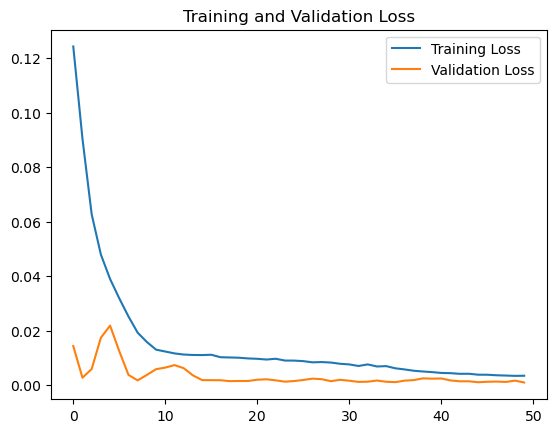

In [10]:
# Kiểm tra overfitting bằng cách vẽ biểu đồ loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## 5. Dự báo

In [11]:
# Dự đoán trên tập huấn luyện và kiểm tra
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

2/2 [==============================] - 0s 2ms/step


In [12]:
def inverse_transform_predictions(scaler, X, predictions):
    # Đảm bảo predictions là một cột với kích thước (num_samples, 1)
    predictions = predictions.reshape(-1, 1)
    
    # X lấy dữ liệu từ time_steps cuối cùng để kết hợp với dự đoán
    X_last = X[:, -1, :]  # Lấy dữ liệu từ các bước thời gian cuối cùng, bao gồm tất cả các biến độc lập
    
    # Kết hợp dữ liệu cuối cùng với dự đoán
    combined = np.hstack([X_last, predictions])
    
    # Đảm bảo combined có số lượng đặc trưng khớp với scaler
    if combined.shape[1] != scaler.n_features_in_:
        raise ValueError(f"combined shape {combined.shape[1]} does not match scaler features {scaler.n_features_in_}")
    
    # Chuyển đổi về dạng gốc
    return scaler.inverse_transform(combined)[:, -1]



In [13]:
print("X_train shape:", X_train.shape)
print("train_predict shape:", train_predict.shape)
print("X_last shape:", X_train[:, -1, :-1].shape)
print("Combined shape:", np.hstack([X_train[:, -1, :-1], train_predict.reshape(-1, 1)]).shape)

X_train shape: (134, 12, 4)
train_predict shape: (134, 1)
X_last shape: (134, 3)
Combined shape: (134, 4)


In [14]:
print("Số lượng cột mà scaler đã được fit:", scaler.n_features_in_)

Số lượng cột mà scaler đã được fit: 5


In [15]:
# Chuyển đổi dự đoán về dạng gốc
train_predict_inv = inverse_transform_predictions(scaler, X_train, train_predict)
test_predict_inv = inverse_transform_predictions(scaler, X_test, test_predict)

# Chuyển đổi y_train và y_test về dạng gốc
y_train_inv = inverse_transform_predictions(scaler, X_train, y_train.reshape(-1, 1))
y_test_inv = inverse_transform_predictions(scaler, X_test, y_test.reshape(-1, 1))

## 6. Đánh giá mô hình

In [16]:
# Đánh giá mô hình
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 1.4214201634889223
Test RMSE: 0.7551150772340092


## 7. Trực quan hoá kết quả

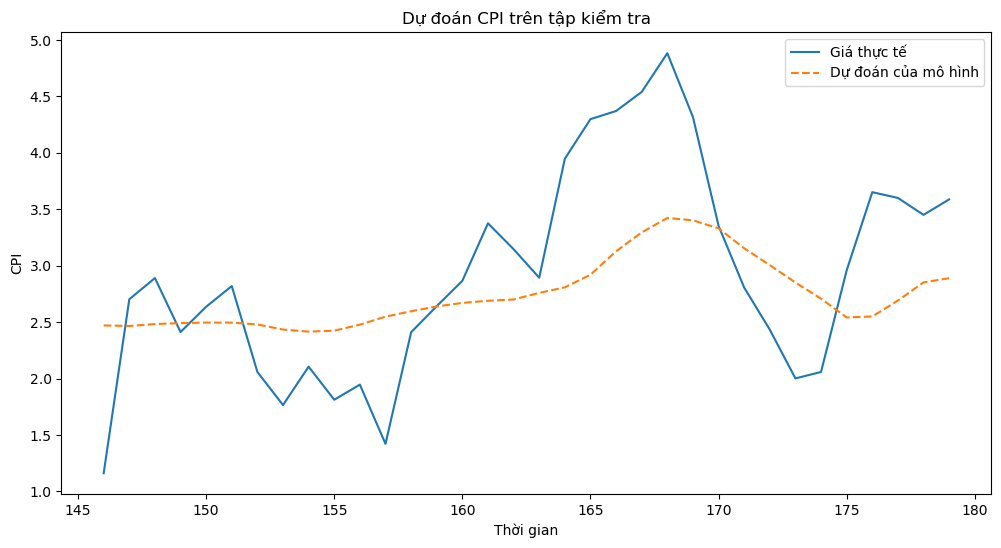

In [17]:
# Vẽ biểu đồ dự đoán và thực tế
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test_inv):], y_test_inv, label='Giá thực tế')
plt.plot(df.index[-len(test_predict_inv):], test_predict_inv, label='Dự đoán của mô hình', linestyle='--')
plt.title('Dự đoán CPI trên tập kiểm tra')
plt.xlabel('Thời gian')
plt.ylabel('CPI')
plt.legend()
plt.show()

## 8. Dự báo cho 10 năm tiếp theo

1/1 [==============================] - 0s 9ms/step
                           TIME  Predicted_CPI
0 1970-02-28 00:00:00.000000179       2.888874
1 1970-03-31 00:00:00.000000179       1.812856
2 1970-04-30 00:00:00.000000179       1.068580
3 1970-05-31 00:00:00.000000179       0.478239
4 1970-06-30 00:00:00.000000179       0.000578


/var/folders/1g/nxkj0vn549s2jk_3fp8ddrq00000gn/T/ipykernel_64103/2208489434.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(last_date, periods=future_steps + 1, freq='M')[1:]  # Bỏ qua thời gian đầu


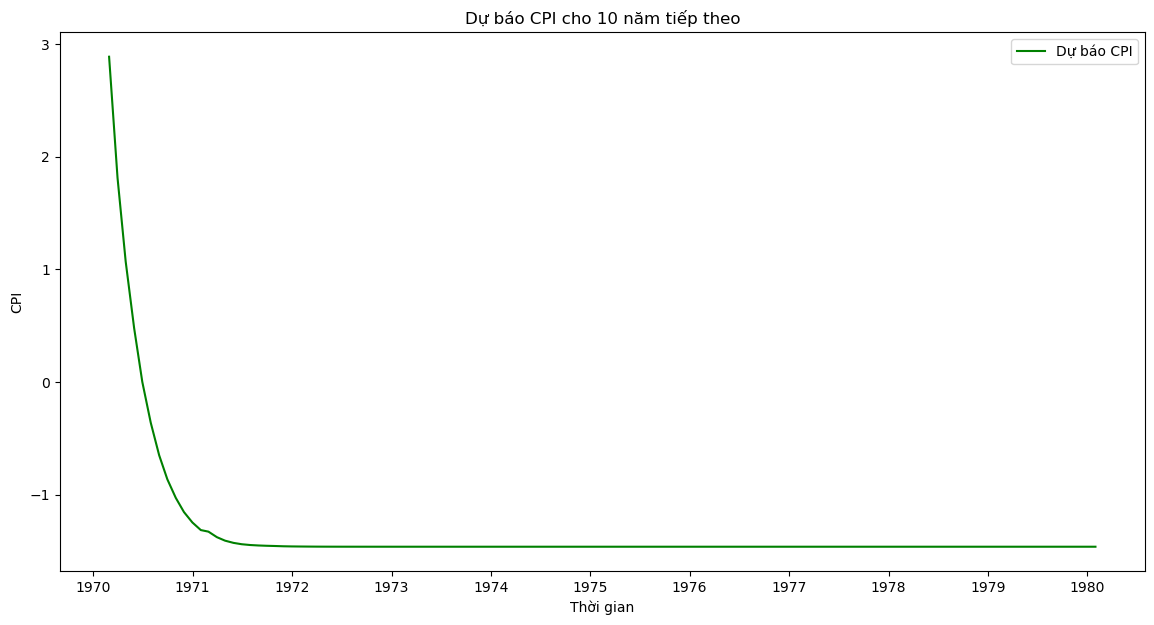

In [18]:
# Dự báo cho 10 năm tiếp theo (120 tháng)
future_steps = 120
last_sequence = X_test[-1]  # Lấy chuỗi dữ liệu cuối cùng từ tập kiểm tra
future_predictions = []

for _ in range(future_steps):
    # Dự báo giá trị tiếp theo
    prediction = model.predict(last_sequence.reshape(1, time_steps, X_train.shape[2]))
    
    # Lưu trữ dự báo
    future_predictions.append(prediction[0, 0])
    
    # Cập nhật chuỗi dữ liệu với giá trị dự báo mới
    # Chuyển đổi dự đoán thành mảng đúng kích thước
    prediction = np.repeat(prediction, X_train.shape[2], axis=-1)  # Nhân bản dự đoán để khớp với số đặc trưng
    new_sequence = np.concatenate((last_sequence[1:], prediction.reshape(1, -1)), axis=0)
    last_sequence = new_sequence

# Tạo ma trận cho các đặc trưng không thay đổi (giả định là 0)
future_features = np.zeros((future_steps, len(features)))  # Ma trận các đặc trưng không bao gồm CPI

# Tạo ma trận kết hợp các đặc trưng và dự đoán CPI
future_data = np.hstack((future_features, np.array(future_predictions).reshape(-1, 1)))

# Chuyển đổi dữ liệu dự báo về dạng gốc
future_predictions_inv = scaler.inverse_transform(future_data)[:, -1]

# Tạo các thời gian cho 10 năm tiếp theo dựa trên thời gian hiện tại
last_date = pd.to_datetime(df.index[-1])
future_dates = pd.date_range(last_date, periods=future_steps + 1, freq='M')[1:]  # Bỏ qua thời gian đầu

# Tạo DataFrame cho dữ liệu dự báo
future_df = pd.DataFrame({'TIME': future_dates, 'Predicted_CPI': future_predictions_inv})

# Hiển thị dữ liệu dự báo
print(future_df.head())

# Vẽ biểu đồ dự báo
plt.figure(figsize=(14, 7))
plt.plot(future_df['TIME'], future_df['Predicted_CPI'], label='Dự báo CPI', color='green')
plt.title('Dự báo CPI cho 10 năm tiếp theo')
plt.xlabel('Thời gian')
plt.ylabel('CPI')
plt.legend()
plt.show()

In [19]:
# Xuất dữ liệu dự báo ra tệp Excel
output_file = "future_inflation_predictions_LSTM.xlsx"
with pd.ExcelWriter(output_file) as writer:
    df.to_excel(writer, sheet_name='Original Data', index=True)
    future_df.to_excel(writer, sheet_name='Future Predictions', index=False)

print(f"Dữ liệu dự báo đã được xuất ra tệp {output_file}")

Dữ liệu dự báo đã được xuất ra tệp future_inflation_predictions_LSTM.xlsx


# B. ANN model

## 1. Chuẩn bị dữ liệu

In [20]:
# Đọc dữ liệu từ file Excel
df = pd.read_excel('data.xlsx')
df

,TIME,CPI,IIR,M2,IIP,ER,CREDIT,WTI,Gold,USD,VN-Index,USD/VND,Trade,Interest-FED,CPI2
0,2009-01-01,17.469,7.88,20.76,76.20,16978.0,1412878.00,41.630909,103.64,101.48,303.21,17484.5,443.281573,0.15,0.32
1,2009-02-01,14.762,7.59,24.14,78.99,16972.0,1429268.00,39.078500,109.59,102.40,245.74,17480.5,847.958418,0.22,1.17
2,2009-03-01,11.257,7.41,26.54,88.06,16954.0,1488011.00,47.980000,115.55,102.60,280.67,17786.0,211.647053,0.18,-0.17
3,2009-04-01,9.231,7.32,32.47,87.82,16937.0,1552442.00,49.905909,117.17,103.88,321.63,17783.0,-1249.972824,0.15,0.35
4,2009-05-01,5.586,6.96,33.88,89.20,16938.0,1600412.00,59.257143,117.88,105.18,411.64,17775.0,-1286.268515,0.18,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2023-08-01,2.958,1.35,8.00,99.88,23977.0,12588304.72,81.372609,103.93,98.84,1224.05,24060.0,3591.981799,5.33,0.88
176,2023-09-01,3.651,1.52,9.31,97.54,24089.0,12754669.12,89.240952,104.91,100.35,1154.15,24280.0,2380.083830,5.33,1.08
177,2023-10-01,3.600,2.48,9.55,104.00,24087.0,12808476.25,85.469091,105.87,101.56,1028.19,24560.0,2908.724742,5.33,0.08
178,2023-11-01,3.450,1.13,10.15,104.02,23891.0,13019793.99,77.575455,108.80,101.61,1094.13,24250.0,1752.122845,5.33,0.25


In [21]:
# Đảm bảo cột TIME là kiểu datetime
df['TIME'] = pd.to_datetime(df['TIME'])

In [22]:
# Lựa chọn các biến độc lập và phụ thuộc
features = ['IIR', 'M2', 'ER', 'CREDIT']
target = 'CPI'

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaler_target = MinMaxScaler()

scaled_df = df.copy()

# Chỉ chuẩn hóa các biến độc lập
scaled_data = scaler.fit_transform(df[features])
# Chỉ chuẩn hóa biến mục tiêu CPI
scaled_target = scaler_target.fit_transform(df[[target]])

# Tạo DataFrame đã chuẩn hóa
scaled_df = pd.DataFrame(scaled_data, index=df.index, columns=features)
scaled_df[target] = scaled_target

## 2. Chia dữ liệu

In [23]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12
data = scaled_df.values
X, y = create_sequences(data, time_steps)



In [24]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


## 3. Xây dựng mô hình ANN

In [25]:
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1] * X_train.shape[2], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Đầu ra duy nhất cho CPI
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                3136      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Chuyển đổi dữ liệu cho ANN
X_train_reshape = X_train.reshape(X_train.shape[0], -1)
X_test_reshape = X_test.reshape(X_test.shape[0], -1)


## 4. Huấn luyện mô hình

In [27]:
history = model.fit(X_train_reshape, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshape, y_test), verbose=1)


Epoch 1/50
5/5 [==============================] - 0s 15ms/step - loss: 0.0350 - val_loss: 0.0099
Epoch 2/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0104 - val_loss: 0.0075
Epoch 3/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0081
Epoch 4/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0106
Epoch 5/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0055
Epoch 6/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 7/50
5/5 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0060
Epoch 8/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 9/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0067
Epoch 10/50
5/5 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0061
Epoch 11/50
5/5 [=====================

## 5. Dự báo

In [28]:
def inverse_transform_predictions(scaler_target, predictions):
    # Đảm bảo predictions là một cột với kích thước (num_samples, 1)
    predictions = predictions.reshape(-1, 1)
    
    # Chuyển đổi dự đoán về dạng gốc
    return scaler_target.inverse_transform(predictions)

train_predict = model.predict(X_train_reshape)
test_predict = model.predict(X_test_reshape)

train_predict_inv = inverse_transform_predictions(scaler_target, train_predict)
test_predict_inv = inverse_transform_predictions(scaler_target, test_predict)

y_train_inv = inverse_transform_predictions(scaler_target, y_train.reshape(-1, 1))
y_test_inv = inverse_transform_predictions(scaler_target, y_test.reshape(-1, 1))



2/2 [==============================] - 0s 1ms/step


## 6. Đánh giá mô hình

In [29]:
# Đánh giá mô hình
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict_inv))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')



Train RMSE: 0.8513149608943572
Test RMSE: 1.7826810021023685


## 7. Trực quan hoá kết quả

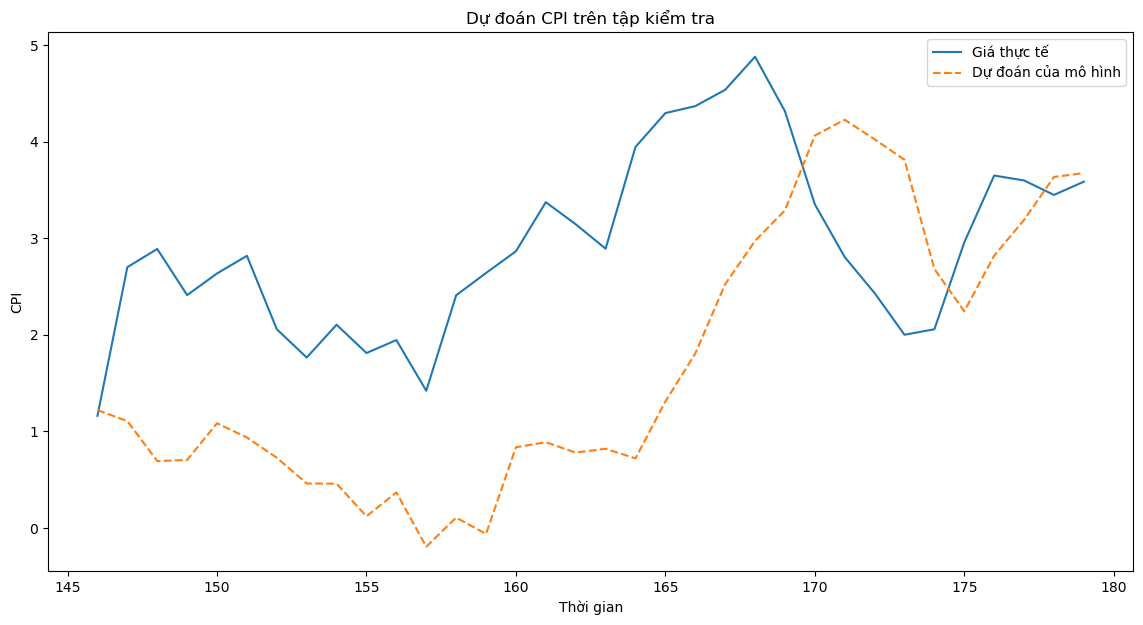

In [30]:
# Vẽ biểu đồ dự đoán và thực tế
plt.figure(figsize=(14, 7))
plt.plot(df.index[-len(y_test_inv):], y_test_inv, label='Giá thực tế')
plt.plot(df.index[-len(test_predict_inv):], test_predict_inv, label='Dự đoán của mô hình', linestyle='--')
plt.title('Dự đoán CPI trên tập kiểm tra')
plt.xlabel('Thời gian')
plt.ylabel('CPI')
plt.legend()
plt.show()


## 8. Dự báo cho 10 năm tiếp theo

# C. LASSO model

## 1. Chuẩn bị dữ liệu

In [31]:
# Đọc dữ liệu từ file Excel
df = pd.read_excel('data.xlsx')
df

,TIME,CPI,IIR,M2,IIP,ER,CREDIT,WTI,Gold,USD,VN-Index,USD/VND,Trade,Interest-FED,CPI2
0,2009-01-01,17.469,7.88,20.76,76.20,16978.0,1412878.00,41.630909,103.64,101.48,303.21,17484.5,443.281573,0.15,0.32
1,2009-02-01,14.762,7.59,24.14,78.99,16972.0,1429268.00,39.078500,109.59,102.40,245.74,17480.5,847.958418,0.22,1.17
2,2009-03-01,11.257,7.41,26.54,88.06,16954.0,1488011.00,47.980000,115.55,102.60,280.67,17786.0,211.647053,0.18,-0.17
3,2009-04-01,9.231,7.32,32.47,87.82,16937.0,1552442.00,49.905909,117.17,103.88,321.63,17783.0,-1249.972824,0.15,0.35
4,2009-05-01,5.586,6.96,33.88,89.20,16938.0,1600412.00,59.257143,117.88,105.18,411.64,17775.0,-1286.268515,0.18,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2023-08-01,2.958,1.35,8.00,99.88,23977.0,12588304.72,81.372609,103.93,98.84,1224.05,24060.0,3591.981799,5.33,0.88
176,2023-09-01,3.651,1.52,9.31,97.54,24089.0,12754669.12,89.240952,104.91,100.35,1154.15,24280.0,2380.083830,5.33,1.08
177,2023-10-01,3.600,2.48,9.55,104.00,24087.0,12808476.25,85.469091,105.87,101.56,1028.19,24560.0,2908.724742,5.33,0.08
178,2023-11-01,3.450,1.13,10.15,104.02,23891.0,13019793.99,77.575455,108.80,101.61,1094.13,24250.0,1752.122845,5.33,0.25


In [32]:
# Đảm bảo cột TIME là kiểu datetime
df['TIME'] = pd.to_datetime(df['TIME'])

In [33]:
from sklearn.preprocessing import StandardScaler

# Giả sử X và y là dữ liệu đầu vào và đầu ra của bạn
X = df[['IIR', 'M2', 'ER', 'CREDIT']].values
y = df['CPI'].values

## 2. Chia dữ liệu

In [34]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tiền xử lý dữ liệu (chuẩn hóa)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

## 3. Xây dựng mô hình LASSO

In [35]:
from sklearn.linear_model import Lasso

# Tạo mô hình LASSO
lasso = Lasso(alpha=0.1)  # alpha là tham số điều chỉnh độ phạt

## 4. Huấn luyện mô hình

In [36]:
# Huấn luyện mô hình
lasso.fit(X_train_scaled, y_train_scaled)

Lasso(alpha=0.1)

## 5. Dự báo

In [37]:
from sklearn.metrics import mean_squared_error, r2_score

# Dự đoán trên tập kiểm tra
y_pred_scaled = lasso.predict(X_test_scaled)

# Chuyển đổi dự đoán về dạng gốc
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

## 6. Đánh giá mô hình

In [38]:
# Đánh giá mô hình
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 6.392846727557723
R^2 Score: 0.7153420744006421


## 7. Trực quan hoá kết quả

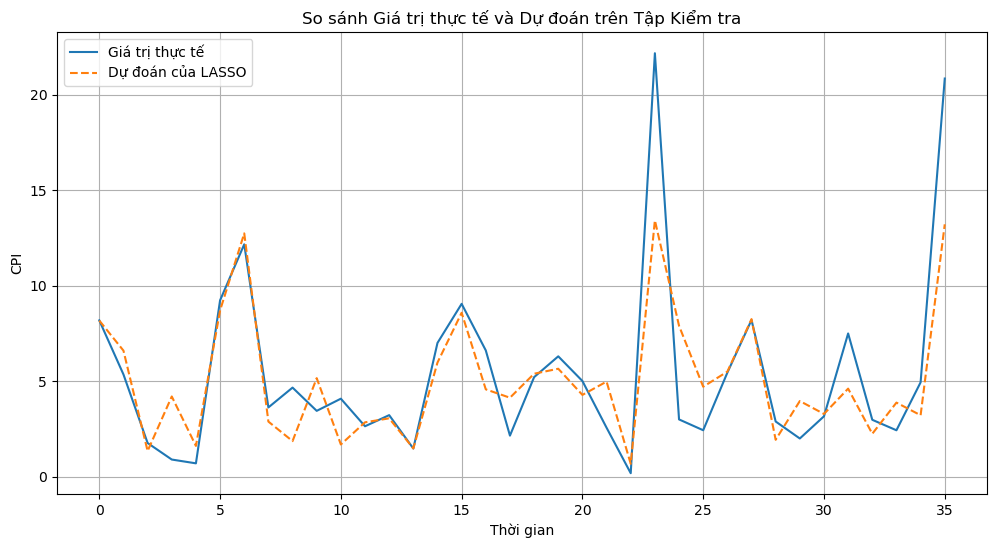

In [39]:
# So sánh giá trị thực tế và dự đoán trên tập kiểm tra
plt.figure(figsize=(12, 6))
plt.plot(y_test_orig, label='Giá trị thực tế')
plt.plot(y_pred, label='Dự đoán của LASSO', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('CPI')
plt.title('So sánh Giá trị thực tế và Dự đoán trên Tập Kiểm tra')
plt.legend()
plt.grid(True)
plt.show()

## 8. Dự báo cho 10 năm tiếp theo

# D. ARIMA model

## 1. Chuẩn bị dữ liệu

In [40]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

In [41]:
# Đọc dữ liệu
df = pd.read_excel('data.xlsx')
df

,TIME,CPI,IIR,M2,IIP,ER,CREDIT,WTI,Gold,USD,VN-Index,USD/VND,Trade,Interest-FED,CPI2
0,2009-01-01,17.469,7.88,20.76,76.20,16978.0,1412878.00,41.630909,103.64,101.48,303.21,17484.5,443.281573,0.15,0.32
1,2009-02-01,14.762,7.59,24.14,78.99,16972.0,1429268.00,39.078500,109.59,102.40,245.74,17480.5,847.958418,0.22,1.17
2,2009-03-01,11.257,7.41,26.54,88.06,16954.0,1488011.00,47.980000,115.55,102.60,280.67,17786.0,211.647053,0.18,-0.17
3,2009-04-01,9.231,7.32,32.47,87.82,16937.0,1552442.00,49.905909,117.17,103.88,321.63,17783.0,-1249.972824,0.15,0.35
4,2009-05-01,5.586,6.96,33.88,89.20,16938.0,1600412.00,59.257143,117.88,105.18,411.64,17775.0,-1286.268515,0.18,0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2023-08-01,2.958,1.35,8.00,99.88,23977.0,12588304.72,81.372609,103.93,98.84,1224.05,24060.0,3591.981799,5.33,0.88
176,2023-09-01,3.651,1.52,9.31,97.54,24089.0,12754669.12,89.240952,104.91,100.35,1154.15,24280.0,2380.083830,5.33,1.08
177,2023-10-01,3.600,2.48,9.55,104.00,24087.0,12808476.25,85.469091,105.87,101.56,1028.19,24560.0,2908.724742,5.33,0.08
178,2023-11-01,3.450,1.13,10.15,104.02,23891.0,13019793.99,77.575455,108.80,101.61,1094.13,24250.0,1752.122845,5.33,0.25


In [42]:
# Chuyển cột TIME thành dạng datetime và thiết lập làm chỉ mục
df['TIME'] = pd.to_datetime(df['TIME'])
df.set_index('TIME', inplace=True)

# Chọn cột CPI cho mô hình dự báo
data = df['CPI']
data

TIME
2009-01-01    17.469
2009-02-01    14.762
2009-03-01    11.257
2009-04-01     9.231
2009-05-01     5.586
               ...  
2023-08-01     2.958
2023-09-01     3.651
2023-10-01     3.600
2023-11-01     3.450
2023-12-01     3.587
Name: CPI, Length: 180, dtype: float64

In [43]:
# Xác định kích thước của tập huấn luyện và tập kiểm tra
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [44]:
from pmdarima import auto_arima

auto_model = auto_arima(train, max_p=5, max_q=5, m=12, d=1,
                       start_P=1, seasonal=True,
                       D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=493.276, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=350.754, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=402.748, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=334.296, Time=0.22 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.27 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=411.623, Time=0.23 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=333.918, Time=0.34 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=348.851, Time=0.06 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=334.592, Time=0.40 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=334.447, Time=

In [45]:
auto_model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [46]:
future_forecast = auto_model.predict(n_periods=len(test))
future_forecast

2021-01-01   -0.781189
2021-02-01   -1.065414
2021-03-01   -1.601769
2021-04-01   -1.725358
2021-05-01   -1.372527
2021-06-01   -1.376944
2021-07-01   -1.368496
2021-08-01   -1.710911
2021-09-01   -1.871388
2021-10-01   -1.812893
2021-11-01   -1.447853
2021-12-01   -0.899460
2022-01-01   -0.568729
2022-02-01   -1.050290
2022-03-01   -1.309868
2022-04-01   -2.141569
2022-05-01   -2.412357
2022-06-01   -2.374183
2022-07-01   -2.133675
2022-08-01   -2.338707
2022-09-01   -2.573158
2022-10-01   -2.696106
2022-11-01   -2.556926
2022-12-01   -2.363657
2023-01-01   -2.263032
2023-02-01   -2.900957
2023-03-01   -3.423726
2023-04-01   -4.426357
2023-05-01   -4.513602
2023-06-01   -4.156621
2023-07-01   -4.035582
2023-08-01   -4.314313
2023-09-01   -4.496788
2023-10-01   -4.714230
2023-11-01   -4.990401
2023-12-01   -5.316500
Freq: MS, dtype: float64

In [47]:
future_forecast = pd.DataFrame(future_forecast,
                              index=test.index,
                              columns=['Prediction'])

In [48]:
future_forecast.head()

,Prediction
TIME,
2021-01-01,-0.781189
2021-02-01,-1.065414
2021-03-01,-1.601769
2021-04-01,-1.725358
2021-05-01,-1.372527


In [49]:
future_forecast.tail()

,Prediction
TIME,
2023-08-01,-4.314313
2023-09-01,-4.496788
2023-10-01,-4.714230
2023-11-01,-4.990401
2023-12-01,-5.316500


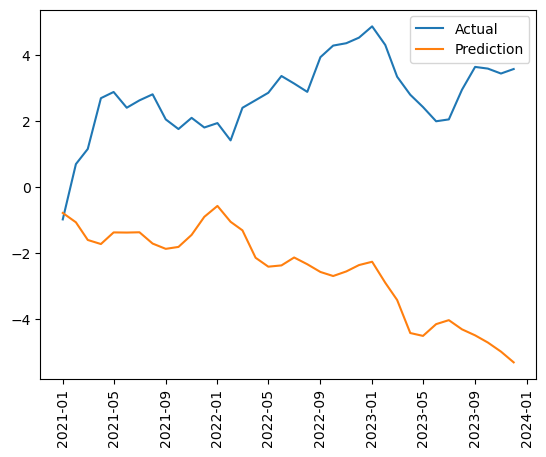

In [50]:
plt.plot(test, label='Actual')
plt.plot(future_forecast, label='Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

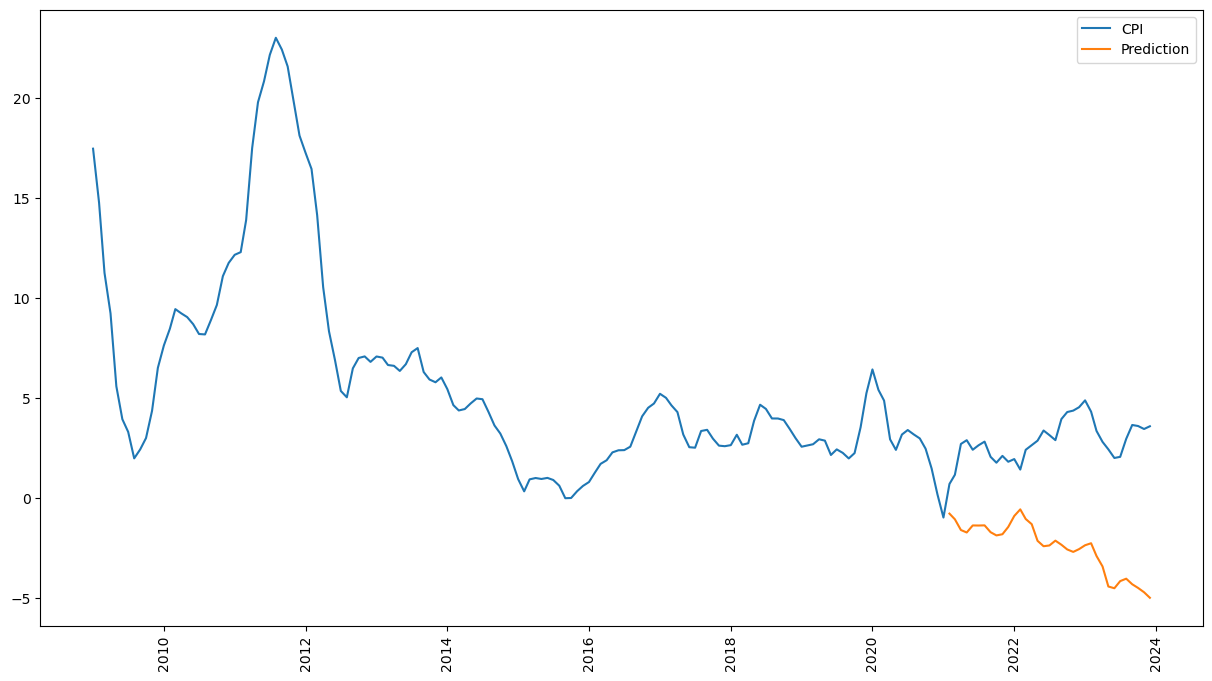

In [51]:
plt.figure(figsize=(15,8))
plt.plot(data, label='CPI')
plt.plot(future_forecast.shift(1), label='Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

In [52]:
# Dự báo 12 tháng tiếp theo
future_forecast_12 = auto_model.predict(n_periods=len(test)+12)
future_forecast_12

2021-01-01   -0.781189
2021-02-01   -1.065414
2021-03-01   -1.601769
2021-04-01   -1.725358
2021-05-01   -1.372527
2021-06-01   -1.376944
2021-07-01   -1.368496
2021-08-01   -1.710911
2021-09-01   -1.871388
2021-10-01   -1.812893
2021-11-01   -1.447853
2021-12-01   -0.899460
2022-01-01   -0.568729
2022-02-01   -1.050290
2022-03-01   -1.309868
2022-04-01   -2.141569
2022-05-01   -2.412357
2022-06-01   -2.374183
2022-07-01   -2.133675
2022-08-01   -2.338707
2022-09-01   -2.573158
2022-10-01   -2.696106
2022-11-01   -2.556926
2022-12-01   -2.363657
2023-01-01   -2.263032
2023-02-01   -2.900957
2023-03-01   -3.423726
2023-04-01   -4.426357
2023-05-01   -4.513602
2023-06-01   -4.156621
2023-07-01   -4.035582
2023-08-01   -4.314313
2023-09-01   -4.496788
2023-10-01   -4.714230
2023-11-01   -4.990401
2023-12-01   -5.316500
2024-01-01   -5.600578
2024-02-01   -5.997801
2024-03-01   -6.399067
2024-04-01   -6.909213
2024-05-01   -6.880613
2024-06-01   -6.846818
2024-07-01   -6.720199
2024-08-01 

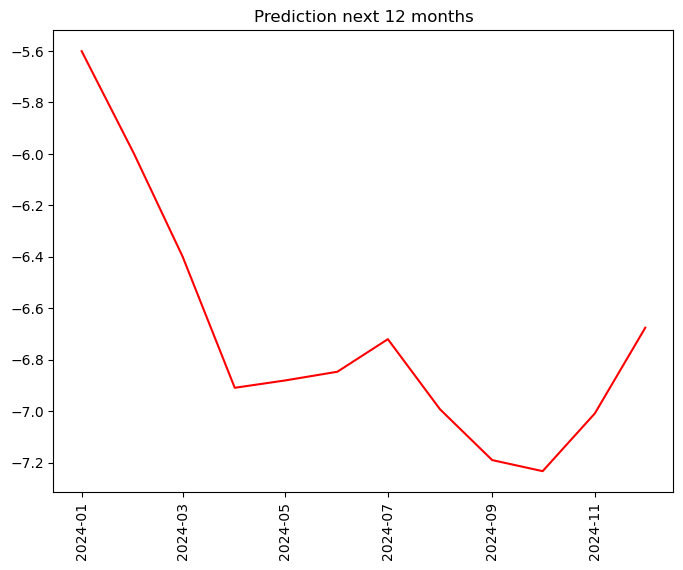

In [53]:
plt.figure(figsize=(8,6))
plt.plot(future_forecast_12[len(test):], color='red')
plt.xticks(rotation='vertical')
plt.title('Prediction next 12 months')
plt.show()

In [54]:
# View future value
future_forecast_12[len(test):]

2024-01-01   -5.600578
2024-02-01   -5.997801
2024-03-01   -6.399067
2024-04-01   -6.909213
2024-05-01   -6.880613
2024-06-01   -6.846818
2024-07-01   -6.720199
2024-08-01   -6.992799
2024-09-01   -7.190272
2024-10-01   -7.233285
2024-11-01   -7.009040
2024-12-01   -6.675538
Freq: MS, dtype: float64